# Class-Conditional Synthesis with Latent Diffusion Models

Install all the requirements

In [3]:
#@title Installation
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/ruizeg2/PycharmProjects/efficient-dit/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers


Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [17]:
#@title Download
%cd latent-diffusion/

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

[Errno 2] No such file or directory: 'latent-diffusion/'
/home/ruizeg2/PycharmProjects/efficient-dit/latent-diffusion


/home/ruizeg2/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


--2024-10-12 02:35:54--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  10.1MB/s    in 1m 56s  

2024-10-12 02:37:51 (15.0 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [18]:
!nvidia-smi

Sat Oct 12 02:38:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:1A:00.0 Off |                  Off |
| N/A   43C    P0             71W /  300W |     940MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Load it.

In [19]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [20]:
! pip install git+https://github.com/openai/CLIP.git@main#egg=clip

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git (to revision main) to /tmp/pip-install-1ksueda2/clip_f6e97d68f68c46c2998d0bc380b348db
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-1ksueda2/clip_f6e97d68f68c46c2998d0bc380b348db
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [21]:
!pip install kornia

Defaulting to user installation because normal site-packages is not writeable


In [24]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from models/ldm/cin256-v2/model.ckpt


/tmp/ipykernel_919483/2112152831.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt)#, map_location="cpu")


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/ruizeg2/.local/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '25' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  6.04it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


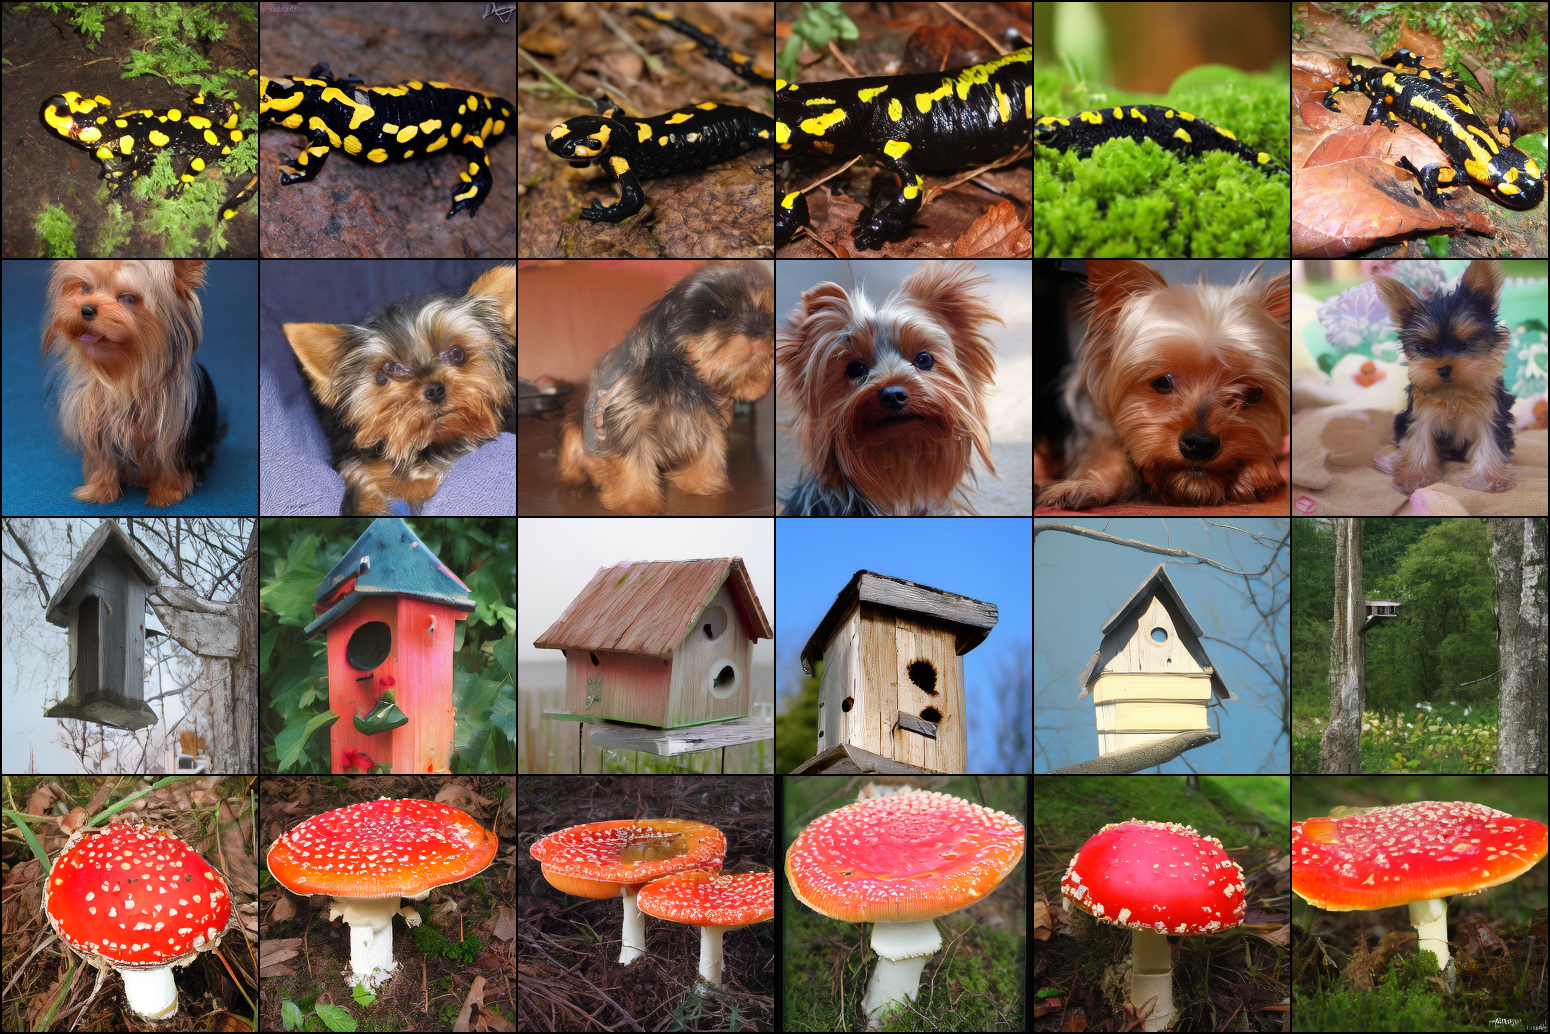

In [25]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torch

classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )

        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))